# Demo Dự Đoán Giá Nhà - Machine Learning vs Deep Learning

## Mục tiêu:
- So sánh hiệu quả giữa Machine Learning truyền thống và Deep Learning
- Thực hành từ thu thập dữ liệu → huấn luyện → test → đánh giá
- Hiểu cách các model hoạt động trong thực tế


In [1]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')


## 1. Tạo Dữ Liệu Giả Lập (Realistic Data)
Trong thực tế, dữ liệu sẽ được thu thập từ các trang web bất động sản


In [2]:
# Tạo dữ liệu giả lập dựa trên thị trường bất động sản Việt Nam
np.random.seed(42)
n_samples = 1000

# Các yếu tố ảnh hưởng đến giá nhà
data = {
    'dien_tich': np.clip(np.random.normal(80, 25, n_samples), 30, 200),  # 30-200 m2
    'so_phong_ngu': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.3, 0.4, 0.15, 0.05]),
    'so_phong_tam': np.random.choice([1, 2, 3], n_samples, p=[0.4, 0.5, 0.1]),
    'khoang_cach_trung_tam': np.clip(np.random.exponential(8, n_samples), 1, 30),  # 1-30 km
    'tuoi_nha': np.random.randint(0, 25, n_samples),  # 0-25 năm
    'gan_truong_hoc': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
    'gan_benh_vien': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
    'co_ho_boi': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
    'co_thang_may': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
}

df = pd.DataFrame(data)

# Tạo công thức tính giá nhà dựa trên logic thực tế
def tinh_gia_nha(row):
    gia_co_so = 50_000_000  # 50 triệu VND/m2
    
    # Yếu tố chính: diện tích
    gia = gia_co_so * row['dien_tich']
    
    # Phòng ngủ và phòng tắm
    gia += row['so_phong_ngu'] * 150_000_000  # Giảm xuống 150tr/phòng
    gia += row['so_phong_tam'] * 80_000_000   # Giảm xuống 80tr/phòng tắm
    
    # Vị trí (càng xa trung tâm càng rẻ) - giảm impact để tránh âm
    distance_factor = max(0.3, 1 - row['khoang_cach_trung_tam'] * 0.015)  # Tối thiểu 30%
    gia *= distance_factor
    
    # Tuổi nhà (càng cũ càng rẻ) - giảm impact
    age_factor = max(0.5, 1 - row['tuoi_nha'] * 0.008)  # Tối thiểu 50%
    gia *= age_factor
    
    # Tiện ích xung quanh
    if row['gan_truong_hoc']: gia *= 1.08
    if row['gan_benh_vien']: gia *= 1.05
    if row['co_ho_boi']: gia *= 1.15
    if row['co_thang_may']: gia *= 1.1
    
    # Đảm bảo giá không âm trước khi thêm noise
    gia = max(gia, 500_000_000)  # Tối thiểu 500 triệu
    
    # Thêm noise nhỏ hơn để tránh giá trị âm
    noise = np.random.normal(0, gia * 0.05)  # Giảm từ 0.1 xuống 0.05
    gia += noise
    
    return max(gia, 500_000_000)  # Đảm bảo giá tối thiểu

df['gia_nha'] = df.apply(tinh_gia_nha, axis=1)

print("📊 Dữ liệu mẫu:")
print(df.head())
print(f"\n📈 Tổng số mẫu: {len(df)}")
print(f"💰 Giá nhà trung bình: {df['gia_nha'].mean():,.0f} VND")
print(f"💰 Giá nhà cao nhất: {df['gia_nha'].max():,.0f} VND")
print(f"💰 Giá nhà thấp nhất: {df['gia_nha'].min():,.0f} VND")


📊 Dữ liệu mẫu:
    dien_tich  so_phong_ngu  so_phong_tam  khoang_cach_trung_tam  tuoi_nha  \
0   92.417854             2             1               8.360224        15   
1   76.543392             2             1               1.000000         2   
2   96.192213             3             1               3.766034        14   
3  118.075746             3             1              13.029559         3   
4   74.146166             1             2               4.545833         4   

   gan_truong_hoc  gan_benh_vien  co_ho_boi  co_thang_may       gia_nha  
0               0              0          0             0  3.714723e+09  
1               1              0          0             0  4.457476e+09  
2               0              0          0             0  4.419347e+09  
3               1              0          0             0  5.691959e+09  
4               1              0          0             0  3.837455e+09  

📈 Tổng số mẫu: 1000
💰 Giá nhà trung bình: 3,965,990,942 VND
💰 Giá nhà c

## 2. Khám Phá Dữ Liệu (Data Exploration)


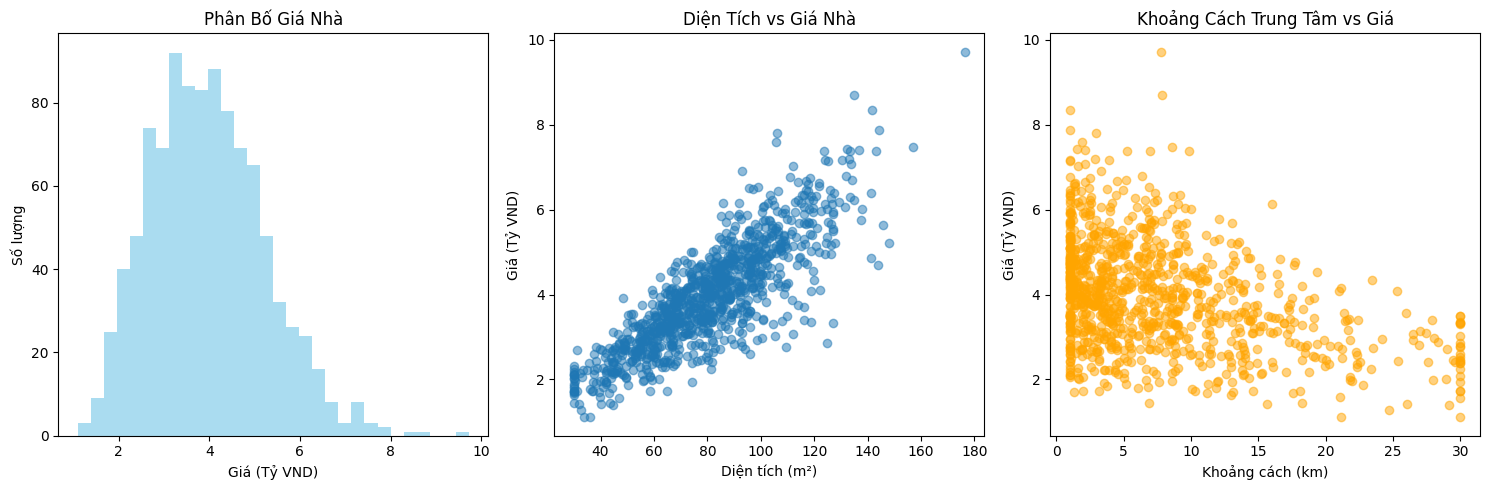

In [3]:
# Vẽ biểu đồ khám phá dữ liệu
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['gia_nha']/1_000_000_000, bins=30, alpha=0.7, color='skyblue')
plt.title('Phân Bố Giá Nhà')
plt.xlabel('Giá (Tỷ VND)')
plt.ylabel('Số lượng')

plt.subplot(1, 3, 2)
plt.scatter(df['dien_tich'], df['gia_nha']/1_000_000_000, alpha=0.5)
plt.title('Diện Tích vs Giá Nhà')
plt.xlabel('Diện tích (m²)')
plt.ylabel('Giá (Tỷ VND)')

plt.subplot(1, 3, 3)
plt.scatter(df['khoang_cach_trung_tam'], df['gia_nha']/1_000_000_000, alpha=0.5, color='orange')
plt.title('Khoảng Cách Trung Tâm vs Giá')
plt.xlabel('Khoảng cách (km)')
plt.ylabel('Giá (Tỷ VND)')

plt.tight_layout()
plt.show()


## 3. Chuẩn Bị Dữ Liệu + Training Models


In [ ]:
# Chuẩn bị dữ liệu
X = df.drop('gia_nha', axis=1)
y = df['gia_nha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📊 Dữ liệu training: {X_train.shape}")
print(f"📊 Dữ liệu testing: {X_test.shape}")

# Training Machine Learning Models
print("\n🔨 Training Machine Learning models...")

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. Deep Learning Model
print("🧠 Training Deep Learning model...")
dl_model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

dl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = dl_model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, 
                      validation_split=0.2, verbose=0)

print("✅ Tất cả models đã được train xong!")


📊 Dữ liệu training: (800, 9)
📊 Dữ liệu testing: (200, 9)

🔨 Training Machine Learning models...
🧠 Training Deep Learning model...
✅ Tất cả models đã được train xong!


## 4. TEST VÀ ĐÁNH GIÁ MODELS


In [10]:
# Dự đoán trên test set
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
dl_pred = dl_model.predict(X_test_scaled, verbose=0).flatten()

# Hàm đánh giá model
def danh_gia_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"📊 {model_name}:")
    print(f"   MAE: {mae:,.0f} VND ({(mae/y_true.mean())*100:.1f}%)")
    print(f"   RMSE: {rmse:,.0f} VND")
    print(f"   R² Score: {r2:.3f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Error_%': (mae/y_true.mean())*100}

# Đánh giá từng model
results = {}
results['Linear Regression'] = danh_gia_model(y_test, lr_pred, "Linear Regression")
results['Random Forest'] = danh_gia_model(y_test, rf_pred, "Random Forest")
results['Deep Learning'] = danh_gia_model(y_test, dl_pred, "Deep Learning")

# Bảng so sánh
results_df = pd.DataFrame(results).T
print("\n🏆 BẢNG XẾP HẠNG:")
print(results_df.round(3))


📊 Linear Regression:
   MAE: 213,369,415 VND (5.5%)
   RMSE: 293,916,673 VND
   R² Score: 0.952
📊 Random Forest:
   MAE: 271,360,160 VND (7.0%)
   RMSE: 400,083,299 VND
   R² Score: 0.911
📊 Deep Learning:
   MAE: 238,713,008 VND (6.1%)
   RMSE: 303,573,012 VND
   R² Score: 0.949

🏆 BẢNG XẾP HẠNG:
                            MAE          RMSE     R2  Error_%
Linear Regression  2.133694e+08  2.939167e+08  0.952    5.482
Random Forest      2.713602e+08  4.000833e+08  0.911    6.972
Deep Learning      2.387130e+08  3.035730e+08  0.949    6.133


## 5. TEST THỰC TẾ - Dự Đoán Giá Nhà Mới


In [11]:
def du_doan_gia_nha(dien_tich, so_phong_ngu, so_phong_tam, khoang_cach_trung_tam, 
                   tuoi_nha, gan_truong_hoc, gan_benh_vien, co_ho_boi, co_thang_may):
    """Hàm dự đoán giá nhà từ các thông số"""
    new_house = pd.DataFrame({
        'dien_tich': [dien_tich], 'so_phong_ngu': [so_phong_ngu],
        'so_phong_tam': [so_phong_tam], 'khoang_cach_trung_tam': [khoang_cach_trung_tam],
        'tuoi_nha': [tuoi_nha], 'gan_truong_hoc': [gan_truong_hoc],
        'gan_benh_vien': [gan_benh_vien], 'co_ho_boi': [co_ho_boi], 'co_thang_may': [co_thang_may]
    })
    
    new_house_scaled = scaler.transform(new_house)
    
    lr_price = lr_model.predict(new_house)[0]
    rf_price = rf_model.predict(new_house)[0]
    dl_price = dl_model.predict(new_house_scaled, verbose=0)[0][0]
    
    return lr_price, rf_price, dl_price

# TEST CASE 1: Nhà cao cấp
print("🏠 TEST CASE 1: Nhà Cao Cấp")
print("150m², 4PN, 3PT, cách TT 5km, 2 năm tuổi, đầy đủ tiện ích")
lr1, rf1, dl1 = du_doan_gia_nha(150, 4, 3, 5, 2, 1, 1, 1, 1)
print(f"   Linear Regression: {lr1/1_000_000_000:.2f} tỷ VND")
print(f"   Random Forest: {rf1/1_000_000_000:.2f} tỷ VND")
print(f"   Deep Learning: {dl1/1_000_000_000:.2f} tỷ VND")

# TEST CASE 2: Nhà bình dân
print("\n🏘️ TEST CASE 2: Nhà Bình Dân")
print("60m², 2PN, 1PT, cách TT 15km, 10 năm tuổi, ít tiện ích")
lr2, rf2, dl2 = du_doan_gia_nha(60, 2, 1, 15, 10, 0, 0, 0, 0)
print(f"   Linear Regression: {lr2/1_000_000_000:.2f} tỷ VND")
print(f"   Random Forest: {rf2/1_000_000_000:.2f} tỷ VND")
print(f"   Deep Learning: {dl2/1_000_000_000:.2f} tỷ VND")

# TEST CASE 3: Nhà trung bình
print("\n🏡 TEST CASE 3: Nhà Trung Bình")
print("100m², 3PN, 2PT, cách TT 8km, 5 năm tuổi, một số tiện ích")
lr3, rf3, dl3 = du_doan_gia_nha(100, 3, 2, 8, 5, 1, 0, 0, 1)
print(f"   Linear Regression: {lr3/1_000_000_000:.2f} tỷ VND")
print(f"   Random Forest: {rf3/1_000_000_000:.2f} tỷ VND")
print(f"   Deep Learning: {dl3/1_000_000_000:.2f} tỷ VND")


🏠 TEST CASE 1: Nhà Cao Cấp
150m², 4PN, 3PT, cách TT 5km, 2 năm tuổi, đầy đủ tiện ích
   Linear Regression: 9.01 tỷ VND
   Random Forest: 7.65 tỷ VND
   Deep Learning: 9.38 tỷ VND

🏘️ TEST CASE 2: Nhà Bình Dân
60m², 2PN, 1PT, cách TT 15km, 10 năm tuổi, ít tiện ích
   Linear Regression: 2.16 tỷ VND
   Random Forest: 2.50 tỷ VND
   Deep Learning: 2.21 tỷ VND

🏡 TEST CASE 3: Nhà Trung Bình
100m², 3PN, 2PT, cách TT 8km, 5 năm tuổi, một số tiện ích
   Linear Regression: 5.47 tỷ VND
   Random Forest: 5.12 tỷ VND
   Deep Learning: 5.35 tỷ VND


## 6. ĐÁNH GIÁ ĐỘ CHÍNH XÁC VÀ KẾT LUẬN


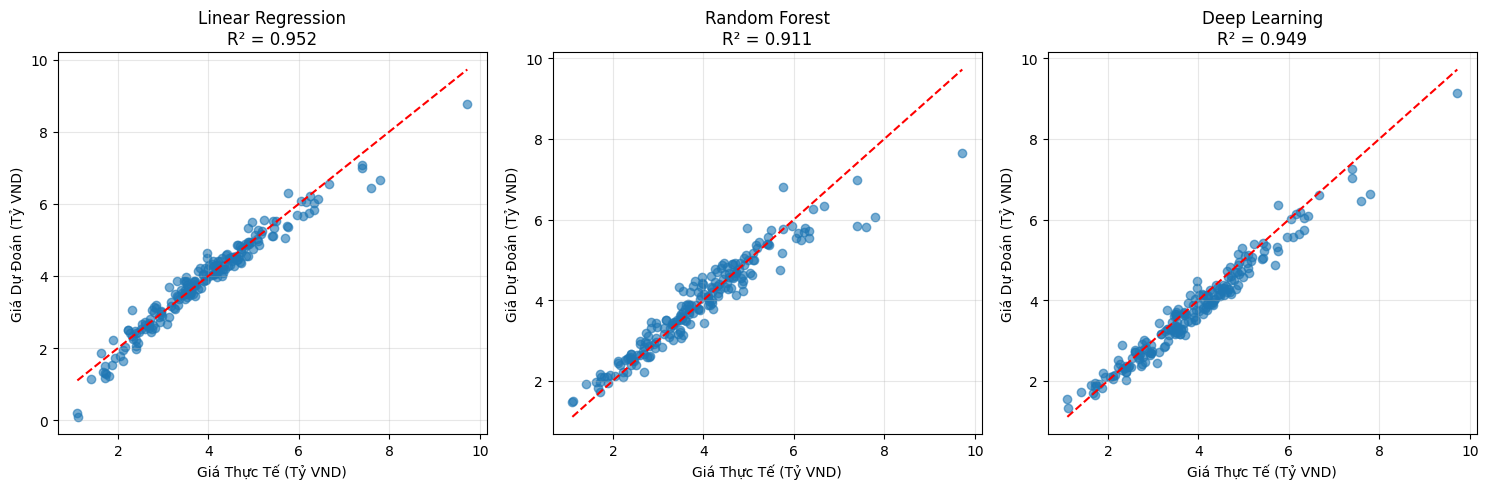

📊 PHÂN TÍCH ĐỘ NHẤT QUÁN:

Nhà Cao Cấp:
   Giá trung bình: 8.68 tỷ VND
   Độ lệch chuẩn: 0.75 tỷ VND
   Hệ số biến thiên: 8.6%
   ✅ Models dự đoán rất nhất quán

Nhà Bình Dân:
   Giá trung bình: 2.29 tỷ VND
   Độ lệch chuẩn: 0.15 tỷ VND
   Hệ số biến thiên: 6.6%
   ✅ Models dự đoán rất nhất quán

Nhà Trung Bình:
   Giá trung bình: 5.31 tỷ VND
   Độ lệch chuẩn: 0.14 tỷ VND
   Hệ số biến thiên: 2.7%
   ✅ Models dự đoán rất nhất quán

🏆 MODEL TỐT NHẤT: Linear Regression
   - Độ chính xác (R²): 0.952
   - Sai số trung bình: 5.5%

💡 KẾT LUẬN:
✅ Model đạt độ chính xác cao, có thể triển khai thực tế

📚 BÀI HỌC:
1. Dữ liệu chất lượng quan trọng hơn thuật toán phức tạp
2. Không phải lúc nào Deep Learning cũng tốt nhất
3. Cần test trên nhiều scenarios để đánh giá độ tin cậy
4. Cân nhắc giữa độ chính xác và khả năng giải thích


In [12]:
# Visualize kết quả dự đoán
plt.figure(figsize=(15, 5))

models = [('Linear Regression', lr_pred), ('Random Forest', rf_pred), ('Deep Learning', dl_pred)]

for i, (name, pred) in enumerate(models, 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test/1_000_000_000, pred/1_000_000_000, alpha=0.6)
    plt.plot([y_test.min()/1_000_000_000, y_test.max()/1_000_000_000], 
             [y_test.min()/1_000_000_000, y_test.max()/1_000_000_000], 'r--')
    plt.xlabel('Giá Thực Tế (Tỷ VND)')
    plt.ylabel('Giá Dự Đoán (Tỷ VND)')
    plt.title(f'{name}\nR² = {results[name]["R2"]:.3f}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tính độ nhất quán giữa các models
test_cases = [
    ('Nhà Cao Cấp', [lr1, rf1, dl1]),
    ('Nhà Bình Dân', [lr2, rf2, dl2]),
    ('Nhà Trung Bình', [lr3, rf3, dl3])
]

print("📊 PHÂN TÍCH ĐỘ NHẤT QUÁN:")
for case_name, predictions in test_cases:
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    cv = (std_pred / mean_pred) * 100
    print(f"\n{case_name}:")
    print(f"   Giá trung bình: {mean_pred/1_000_000_000:.2f} tỷ VND")
    print(f"   Độ lệch chuẩn: {std_pred/1_000_000_000:.2f} tỷ VND")
    print(f"   Hệ số biến thiên: {cv:.1f}%")
    if cv < 10:
        print(f"   ✅ Models dự đoán rất nhất quán")
    elif cv < 20:
        print(f"   ⚠️ Models dự đoán khá nhất quán")
    else:
        print(f"   ❌ Models dự đoán không nhất quán")

# Tìm model tốt nhất
best_model = max(results.items(), key=lambda x: x[1]['R2'])
print(f"\n🏆 MODEL TỐT NHẤT: {best_model[0]}")
print(f"   - Độ chính xác (R²): {best_model[1]['R2']:.3f}")
print(f"   - Sai số trung bình: {best_model[1]['Error_%']:.1f}%")

print("\n💡 KẾT LUẬN:")
if best_model[1]['R2'] > 0.85:
    print("✅ Model đạt độ chính xác cao, có thể triển khai thực tế")
else:
    print("⚠️ Cần cải thiện model hoặc thu thập thêm dữ liệu")
    
print("\n📚 BÀI HỌC:")
print("1. Dữ liệu chất lượng quan trọng hơn thuật toán phức tạp")
print("2. Không phải lúc nào Deep Learning cũng tốt nhất")
print("3. Cần test trên nhiều scenarios để đánh giá độ tin cậy")
print("4. Cân nhắc giữa độ chính xác và khả năng giải thích")
